# Classification - Workshop

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import colors
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from astroML.datasets import fetch_rrlyrae_combined
from astroML.utils import split_samples
from astroML.utils import completeness_contamination

## Data set for the current Workshop

Emission line ratios strongly depend on the heating mechanism which generates them: they can therefore be used to classify sources.
In particular, in literature it is common to find a ($x$,$y$) plot with 2 emission line ratios (hereafter **diagnostic**), and one or more theoretical (or empirical) **curves** separating different objects.

This technique is widespread, and it is routinely adopted for the classification of both galactic and extragalactic sources.

In this exercise we will use **machine learning** classification - as opposed to a simple curve - to separate object types.
Additionally, we will expend the analysis to higher dimensions, i.e. beyond the canonical ($x$,$y$) plane which exploits only 2 diagnostics at a time.

In particular, we will use a set of 7 diagnostics generated by simulations reproducing the emission of "starforming" and "shock-heated" objects.

### Loading and setting up the data

In [2]:
# CREATING DATA STRUCTURE

# > Loading the emission line data and classifications:

PATH_lines_data = "data/emission_lines.txt" 

data = np.genfromtxt(PATH_lines_data)
# The data file is organized in 8080 lines (i.e. different objects), and 10 columns

NII_diagnostic   = data[:,3]  # log10 ( NII  / H_alpha )
SII_diagnostic   = data[:,4]  # log10 ( SII  / H_alpha )
OII_diagnostic   = data[:,5]  # log10 ( OII  / H_beta  )
OI_diagnostic    = data[:,6]  # log10 ( OI   / H_alpha )
OIf_diagnostic   = data[:,7]  # log10 ( OIf  / H_beta  )
OIIf_diagnostic  = data[:,8]  # log10 ( OIIf / H_beta  )
OIII_diagnostic  = data[:,9]  # log10 ( OIII / H_beta  )

labels = np.genfromtxt(PATH_lines_data, delimiter=' ', usecols=0, dtype=str)
# reading labels from first column
# Emission class labelling scheme:
#   0 <-> starburst
#   1 <-> shocked

# Dictionary containg class name and associated label:
from collections import OrderedDict
classes = OrderedDict()
classes["starburst"] = 0
classes["shocked"]   = 1

labels = [int(float(label)) for label in labels]
# converting labels from strings to integers

# > Organizing data in an analysis-ready fashion:
X_sample = np.stack((OIII_diagnostic,      # diagnostic 0
              NII_diagnostic,              # diagnostic 1
              SII_diagnostic,              # diagnostic 2
              OII_diagnostic,              # diagnostic 3
              OI_diagnostic,               # diagnostic 4
              OIf_diagnostic,              # diagnostic 5
              OIIf_diagnostic),axis=-1)    # diagnostic 6
y_sample = labels

print('Sample shape:')
print("_____________________________________")
print('  X  | ' + str(X_sample.shape))
print('     | ' + str(X_sample.shape[0]) + ' sammples x ' + str(X_sample.shape[1]) + ' diagnostics' )
print("-----|-------------------------------")
print('  y  | ' + str(len(y_sample)) + ' labels')

Sample shape:
_____________________________________
  X  | (8080, 7)
     | 8080 sammples x 7 diagnostics
-----|-------------------------------
  y  | 8080 labels


### Visualizing the data

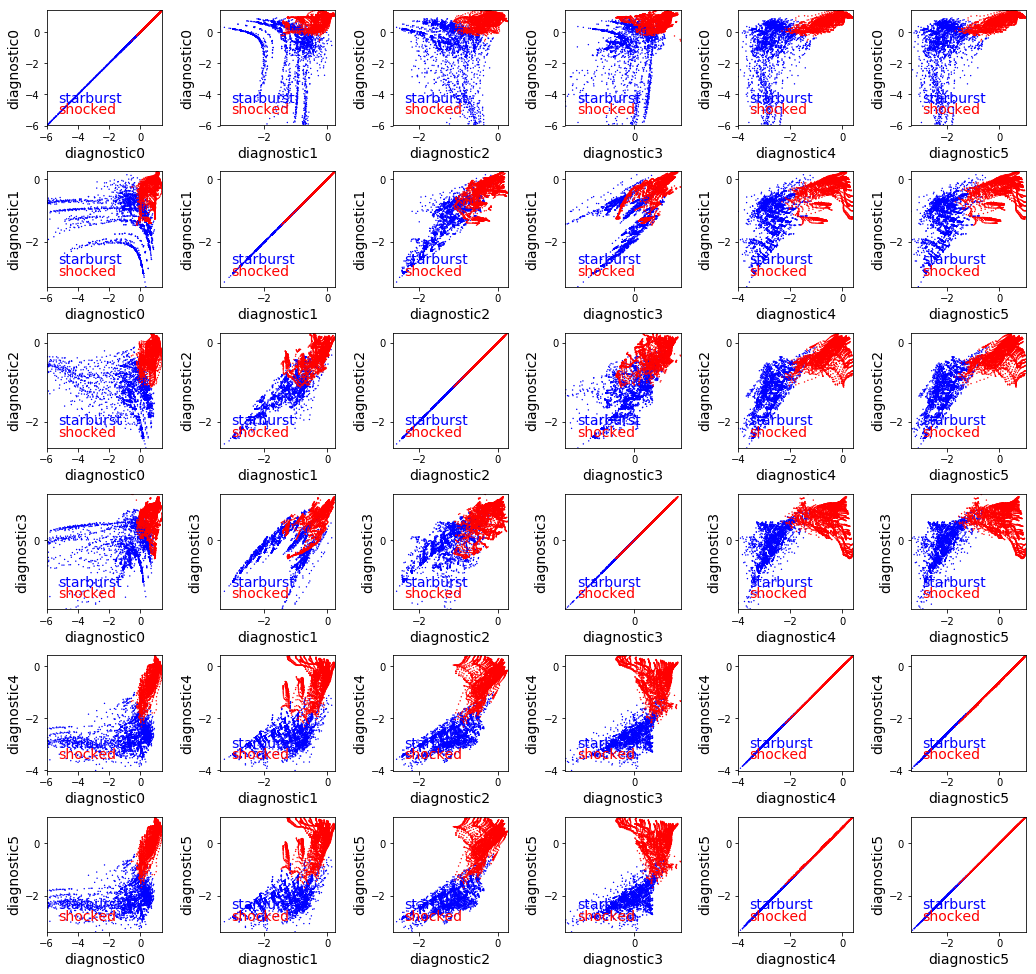

In [3]:
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import colors
%matplotlib inline

# Creating a colormap where:
#   blue <-> starburst
#   red  <-> shocked
cmap = mpl.colors.ListedColormap(['blue','red'])

# Remeber that the sample X is organized as:
#  X[:,0] <-> diagnostic 0
#  X[:,1] <-> diagnostic 1
#  X[:,2] <-> ...


# PLOT EACH DIAGNOSITCS AGAINST THE OTHERS

fig = plt.figure(figsize=(16, 16))
fig.subplots_adjust(bottom=0.15, top=0.95, hspace=0.4, left=0.1, right=0.95, wspace=0.5)

plot_counter= 0
n_rows = int(X_sample.shape[1]) - 1
n_cols = int(X_sample.shape[1]) - 1

for j in range(n_cols):
    for i in range(n_rows):


            plot_counter+=1
            xlim = [np.min(X_sample[:, i]),np.max(X_sample[:, i])]
            ylim = [np.min(X_sample[:, j]),np.max(X_sample[:, j])]

            ax = fig.add_subplot(n_rows, n_cols, plot_counter)
            im = ax.scatter(X_sample[:, i], X_sample[:, j], c=y_sample, s=2, lw=0, cmap=cmap, zorder=2)
            ax.set_xlim(xlim)
            ax.set_ylim(ylim)
            ax.xaxis.set_major_locator(plt.MultipleLocator(2))
            ax.yaxis.set_major_locator(plt.MultipleLocator(2))
            ax.set_xlabel('diagnostic' + str(i), fontsize=14)
            ax.set_ylabel('diagnostic' + str(j), fontsize=14)

            # legend:
            ax.text(0.1,0.20, "starburst", color='blue', transform=ax.transAxes, fontsize=14)
            ax.text(0.1,0.10, "shocked",   color='red',  transform=ax.transAxes, fontsize=14)


plt.show()

## A. EXERCISE: Classify starburst/shocked objects

### TASK A.1: Choose 3 diagnostics and perform classiffication using linear SVM

### TASK A.2: Choose 2 diagnostics and perform classiffication using non-linear SVM (e.g. with Gaussian or polynomial kernel)

### TASK A.1: Choosing 3 diagnostics and performing classiffication using linear SVM

In [4]:
# SELECTING DIAGNOSTIC

X = np.stack((OIII_diagnostic,
              OII_diagnostic,
              OI_diagnostic),axis=-1)

y = y_sample

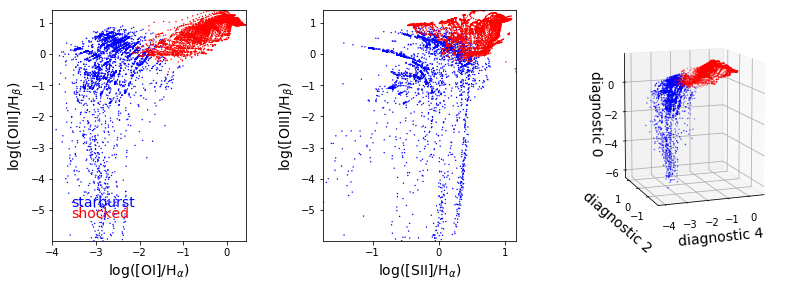

In [5]:
# VISUALIZING DIAGNOSTICS OF INTEREST

import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import colors
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

# Creating a colormap where:
#   blue <-> starburst
#   red  <-> shocked
cmap = mpl.colors.ListedColormap(['blue','red'])

# Remeber that the sample X is organized as:
#  X[:,0] <-> diagnostic 0
#  X[:,1] <-> diagnostic 1
#  X[:,2] <-> ...

fig = plt.figure(figsize=(12, 4))
fig.subplots_adjust(bottom=0.15, top=0.95, hspace=0.0, left=0.1, right=0.95, wspace=0.4)

ylim = [np.min(X[:, 0]),np.max(X[:, 0])]

# > left plot

xlim = [np.min(X[:, 2]),np.max(X[:, 2])]

ax = fig.add_subplot(131)
im = ax.scatter(X[:, 2], X[:, 0], c=y, s=2, lw=0, cmap=cmap, zorder=2)
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.xaxis.set_major_locator(plt.MultipleLocator(1))
ax.yaxis.set_major_locator(plt.MultipleLocator(1))
ax.set_xlabel('log([OI]/H$_{α})$', fontsize=14)
ax.set_ylabel('log([ΟIII]/H$_{β})$', fontsize=14)

# legend:
ax.text(0.1,0.15, "starburst", color='blue', transform=ax.transAxes, fontsize=14)
ax.text(0.1,0.10, "shocked",   color='red',  transform=ax.transAxes, fontsize=14)

# > central plot

xlim = [np.min(X[:, 1]),np.max(X[:, 1])]

ax = fig.add_subplot(132)
im = ax.scatter(X[:, 1], X[:, 0], c=y, s=2, lw=0, cmap=cmap, zorder=2)
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.xaxis.set_major_locator(plt.MultipleLocator(1))
ax.yaxis.set_major_locator(plt.MultipleLocator(1))
ax.set_xlabel('log([SII]/H$_{α})$', fontsize=14)
ax.set_ylabel('log([ΟIII]/H$_{β})$', fontsize=14)

# > right plot
ax = fig.add_subplot(133, projection='3d')
ax.view_init(10, -110)  # set camera position for better visualization
ax.scatter(X[:, 2], X[:, 1], X[:, 0], c=y, s=2, lw=0, cmap=cmap, zorder=2)
ax.set_xlabel('diagnostic 4', fontsize=14)
ax.set_ylabel('diagnostic 2', fontsize=14)
ax.set_zlabel('diagnostic 0', fontsize=14)

plt.show()

In [6]:
# Split the sample in a training [75% of total] and test [25% of total] subsets:
(X_train, X_test), (y_train, y_test) = split_samples(X, y, [0.75, 0.25], random_state=0)

N_tot = len(y)          # number of stars
N_train = len(y_train)  # size of training sample
N_test = len(y_test)    # size of test sample
N_diagnostics = np.arange(1, X.shape[1] + 1)    # number of available diagnostics

print("Sample size")
print("----------------")
print("Total           | %d" % (len(X)))
print(" '-> Train      | %d" % (len(X_train)))
print("     data shape |", ((X_train.shape)))
print(" '-> Test       | %d" % (len(X_test)))
print("     data shape |", ((X_test.shape)))

Sample size
----------------
Total           | 8080
 '-> Train      | 6060
     data shape | (6060, 3)
 '-> Test       | 2020
     data shape | (2020, 3)


In [7]:
# PERFORMING LINEAR SVM CLASSIFICATION

clf = SVC(kernel='linear', gamma='auto', class_weight='balanced')
clf.fit(X_train, y_train)
y_test_pred = clf.predict(X_test)

completeness, contamination = completeness_contamination(y_test_pred, y_test)

print("Summary:")
print("--------")

print("completeness: %.2f " % (completeness), end="")
print("contamination: %.2f" % (contamination))


Summary:
--------
completeness: 0.98 contamination: 0.01


### Visualizing the 3D boundary

If you did things right, the next block should help you visualizing the SVM decision hyperplane

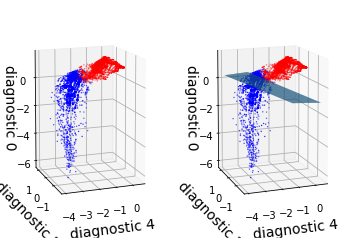

In [8]:
# PLOT THE DECISION BOUNDARY

#%matplotlib notebook
# Will allow to inspect the image:
# - left click+drag  to rotate
# - right click+drag to zoom
#
# For a static image, uncomment the following line:
%matplotlib inline

# The equation of the separating plane is given by all x in R^3 such that:
# np.dot(svc.coef_[0], x) + b = 0. We should solve for the last coordinate
# to plot the plane in terms of x and y.
#
# See: https://stackoverflow.com/questions/36232334/plotting-3d-decision-boundary-from-linear-svm

z = lambda x,y: (-clf.intercept_[0]-clf.coef_[0][0]*x-clf.coef_[0][1]*y) / clf.coef_[0][2]

xlim = [np.min(X_train[:, 2]),np.max(X_train[:, 2])]
ylim = [np.min(X_train[:, 1]),np.max(X_train[:, 1])]

XX, YY = np.meshgrid(np.linspace(xlim[0], xlim[1], 50), np.linspace(ylim[0], ylim[1], 50))

fig = plt.figure()

# > left plot
ax = fig.add_subplot(121, projection='3d')
ax.view_init(10, -110)  # set camera position for better visualization
ax.scatter(X_train[:, 2], X_train[:, 1], X_train[:, 0], c=y_train, s=2, lw=0, cmap=cmap, zorder=2)
ax.set_xlabel('diagnostic 4', fontsize=14)
ax.set_ylabel('diagnostic 2', fontsize=14)
ax.set_zlabel('diagnostic 0', fontsize=14)

# > right plot
ax  = fig.add_subplot(122, projection='3d')
ax.view_init(10, -110)  # set camera position for better visualization
ax.plot_surface(XX, YY, z(XX,YY))
ax.scatter(X_train[:, 2], X_train[:, 1], X_train[:, 0], c=y_train, s=2, lw=0, cmap=cmap, zorder=2)
ax.set_xlabel('diagnostic 4', fontsize=14)
ax.set_ylabel('diagnostic 2', fontsize=14)
ax.set_zlabel('diagnostic 0', fontsize=14)

plt.show()

### Q: Which combination of diagnostics yielded best results?

Compare completeness and contamination obtained with different choices to evaluate the results.

### RESPONSE TO A.2: Choosing 2 diagnostics and performing classiffication using SVM with Gaussian kernel

In [9]:
# SELECTING DIAGNOSTIC

X = np.stack((OIII_diagnostic,
              OI_diagnostic),axis=-1)

y = y_sample

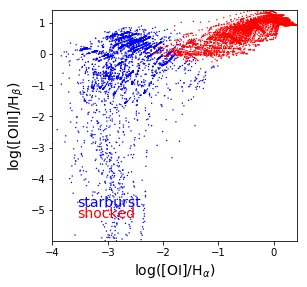

In [10]:
# VISUALIZING DIAGNOSTICS OF INTEREST

import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import colors
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

# Creating a colormap where:
#   blue <-> starburst
#   red  <-> shocked
cmap = mpl.colors.ListedColormap(['blue','red'])

# Remeber that the sample X is organized as:
#  X[:,0] <-> diagnostic 0
#  X[:,1] <-> diagnostic 1
#  X[:,2] <-> ...

fig = plt.figure(figsize=(4, 4))
fig.subplots_adjust(bottom=0.15, top=0.95, hspace=0.0, left=0.1, right=0.95, wspace=0.4)

ylim = [np.min(X[:, 0]),np.max(X[:, 0])]

# plot

xlim = [np.min(X[:, 1]),np.max(X[:, 1])]

ax = fig.add_subplot(111)
im = ax.scatter(X[:, 1], X[:, 0], c=y, s=2, lw=0, cmap=cmap, zorder=2)
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.xaxis.set_major_locator(plt.MultipleLocator(1))
ax.yaxis.set_major_locator(plt.MultipleLocator(1))
ax.set_xlabel('log([OI]/H$_{α})$', fontsize=14)
ax.set_ylabel('log([ΟIII]/H$_{β})$', fontsize=14)

# legend:
ax.text(0.1,0.15, "starburst", color='blue', transform=ax.transAxes, fontsize=14)
ax.text(0.1,0.10, "shocked",   color='red',  transform=ax.transAxes, fontsize=14)

plt.show()

In [11]:
# Split the sample in a training [75% of total] and test [25% of total] subsets:
(X_train, X_test), (y_train, y_test) = split_samples(X, y, [0.75, 0.25], random_state=0)

N_tot = len(y)          # number of stars
N_train = len(y_train)  # size of training sample
N_test = len(y_test)    # size of test sample
N_diagnostics = np.arange(1, X.shape[1] + 1)    # number of available diagnostics

print("Sample size")
print("----------------")
print("Total           | %d" % (len(X)))
print(" '-> Train      | %d" % (len(X_train)))
print("     data shape |", ((X_train.shape)))
print(" '-> Test       | %d" % (len(X_test)))
print("     data shape |", ((X_test.shape)))

Sample size
----------------
Total           | 8080
 '-> Train      | 6060
     data shape | (6060, 2)
 '-> Test       | 2020
     data shape | (2020, 2)


In [12]:
# PERFORMING SVM CLASSIFICATION WITH GAUSSIAN KERNEL

clf = SVC(kernel='rbf', gamma=20.0, class_weight='balanced')
#clf = SVC(kernel='poly', gamma=0.4, degree=3, coef0=1.0, class_weight=None)

clf.fit(X_train, y_train)
y_test_pred = clf.predict(X_test)

completeness, contamination = completeness_contamination(y_test_pred, y_test)

print("Summary:")
print("--------")

print("completeness: %.2f " % (completeness), end="")
print("contamination: %.2f" % (contamination))

Summary:
--------
completeness: 0.99 contamination: 0.01


### Visualizing the 2D boundary

If you did things right, the next block should help you visualizing the SVM decision hypercurve

/usr/local/lib/python3.4/dist-packages/matplotlib/contour.py:1230: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


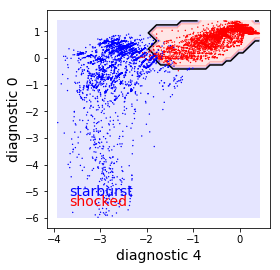

In [13]:
# PLOT THE DECISION BOUNDARY
%matplotlib inline

xlim = [np.min(X_train[:, 1]),np.max(X_train[:, 1])]
ylim = [np.min(X_train[:, 0]),np.max(X_train[:, 0])]

# Creating a grid Z of predictions:
xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 50), np.linspace(ylim[0], ylim[1], 50))
Z = clf.predict(np.c_[yy.ravel(), xx.ravel()])
Z = Z.reshape(xx.shape)
# Smooth the boundary:
#from scipy.ndimage import gaussian_filter
#Z = gaussian_filter(Z, 2)

fig = plt.figure(figsize=(4, 4))

# plot
ax = fig.add_subplot(111)
ax.set_xlabel('diagnostic 4', fontsize=14)
ax.set_ylabel('diagnostic 0', fontsize=14)
ax.contourf(xx, yy, Z > 0, alpha=0.1, cmap=cmap)
ax.contour(xx, yy, Z, colors=['k'], linestyles=['-'],levels=[0])
ax.scatter(X_train[:, 1], X_train[:, 0], c=y_train, s=2, lw=0, cmap=cmap, zorder=2)

# legend:
ax.text(0.1,0.15, "starburst", color='blue', transform=ax.transAxes, fontsize=14)
ax.text(0.1,0.10, "shocked",   color='red',  transform=ax.transAxes, fontsize=14)

plt.show()

### Q: Which method (3D linear vs. 2D non-linear) yielded best results? Which is best to use?

Given that the results are similar, it is better to use the linear SVM in the 3D space.
While formally equivalent from the classification point of view, this approach uses the most information (i.e. diagnostics) and the least assumption (kernel model).

## B. EXERCISE: Calibrate classifier hyperparameter

### TASK B.1: Run the KNN classifier on the starburst/shocked sample for different values of $k$

### TASK B.2: Choose the $k$ which maximize accuracy without overfitting

To achieve this, you will first need to split the sample in a training, validation, and test set.

Then, for each $k$ you will have to:
- train the classifier (i.e. fit the model) on the training set
- evaluate the prediction (i.e. completeness and contamination) on the validation set

After having identified the $k$ wich best compromises completenss and contamination, assess the model performance (i.e. calculate once more completenss and contamination) on the independent test set.

In [110]:
### Loading and setting up the data

# CREATING DATA STRUCTURE

# > Loading the emission line data and classifications:

PATH_lines_data = "data/emission_lines.txt" 

data = np.genfromtxt(PATH_lines_data)
# The data file is organized in 8080 lines (i.e. different objects), and 10 columns

diagnostic_0 = data[:,3]
diagnostic_1 = data[:,4]
diagnostic_2 = data[:,5]
diagnostic_3 = data[:,6]
diagnostic_4 = data[:,7]
diagnostic_5 = data[:,8]
diagnostic_6 = data[:,9]

labels = np.genfromtxt(PATH_lines_data, delimiter=' ', usecols=0, dtype=str)
# reading labels from first column
# Emission class labelling scheme:
#   0 <-> starburst
#   1 <-> shocked

# Dictionary containg class name and associated label:
from collections import OrderedDict
classes = OrderedDict()
classes["starburst"] = 0
classes["shocked"]   = 1

labels = [int(float(label)) for label in labels]
# converting labels from strings to integers

# > Organizing data in an analysis-ready fashion:
# NOTE: We will only use 2 diagnostics for this exercise
X_sample = np.stack((diagnostic_0,
              diagnostic_4),axis=-1)
y_sample = labels

print('Sample shape:')
print("_____________________________________")
print('  X  | ' + str(X_sample.shape))
print('     | ' + str(X_sample.shape[0]) + ' sammples x ' + str(X_sample.shape[1]) + ' diagnostics' )
print("-----|-------------------------------")
print('  y  | ' + str(len(y_sample)) + ' labels')

Sample shape:
_____________________________________
  X  | (8080, 2)
     | 8080 sammples x 2 diagnostics
-----|-------------------------------
  y  | 8080 labels


In [111]:
# Split the sample in a training [75% of total] and test [25% of total] subsets:
(X_train, X_valid, X_test), (y_train, y_valid, y_test) = split_samples(X_sample, y_sample, [0.8, 0.1, 0.1], random_state=0)

N_tot = len(y)          # number of stars
N_st = np.sum(y == 0)   # number of non-RR Lyrae stars
N_rr = N_tot - N_st     # number of RR Lyrae
N_train = len(y_train)  # size of training sample
N_test = len(y_test)    # size of test sample
N_plot = 5000 + N_rr    # number of stars plotted (for better visualization)
Ncolors = np.arange(1, X.shape[1] + 1)    # number of available colors

print("Sample size")
print("----------------")
print("Total           | %d" % (len(X)))
print(" '-> Train      | %d" % (len(X_train)))
print("     data shape |", ((X_train.shape)))
print(" '-> Validation | %d" % (len(X_valid)))
print("     data shape |", ((X_test.shape)))
print(" '-> Test       | %d" % (len(X_test)))
print("     data shape |", ((X_test.shape)))

Sample size
----------------
Total           | 1
 '-> Train      | 6464
     data shape | (6464, 2)
 '-> Validation | 808
     data shape | (808, 2)
 '-> Test       | 808
     data shape | (808, 2)


### RESPONSE TO B.1: Running the KNN classifier on the starburst/shocked sample for different values of $k$

In [112]:
# PERFORM CLASSIFICATION FOR VARIOUS VALUES OF k

# for each 'k', store the classifier and predictions on test sample
classifiers = [] 
predictions = []
kvals = np.arange(1, 22, 1) # k values to be used
kvals = list(kvals)

for k in kvals:
# trying different k hyperparameters

    clf = KNeighborsClassifier(n_neighbors=k) # define the classifier, in this case KNN with hyperparameter k
    clf.fit(X_train, y_train)     # fit training data
    y_pred = clf.predict(X_valid) # predict class of validation set

    classifiers.append(clf)
    predictions.append(y_pred)

# Use dedicated astroML to obtain completeness and contamination:
completeness, contamination = completeness_contamination(predictions, y_valid)

print("Summary:")
print("--------")

for i,k in enumerate(kvals):
    print("k = %-2s | " % k, end='')
    print("completeness: %.3f " % (completeness[i]), end="")
    print("contamination: %.3f" % (contamination[i]))

Summary:
--------
k = 1  | completeness: 0.987 contamination: 0.019
k = 2  | completeness: 0.981 contamination: 0.014
k = 3  | completeness: 0.992 contamination: 0.021
k = 4  | completeness: 0.989 contamination: 0.013
k = 5  | completeness: 0.995 contamination: 0.026
k = 6  | completeness: 0.992 contamination: 0.016
k = 7  | completeness: 0.995 contamination: 0.026
k = 8  | completeness: 0.992 contamination: 0.021
k = 9  | completeness: 0.997 contamination: 0.024
k = 10 | completeness: 0.997 contamination: 0.021
k = 11 | completeness: 0.997 contamination: 0.024
k = 12 | completeness: 0.997 contamination: 0.016
k = 13 | completeness: 0.997 contamination: 0.021
k = 14 | completeness: 0.997 contamination: 0.021
k = 15 | completeness: 0.997 contamination: 0.024
k = 16 | completeness: 0.997 contamination: 0.024
k = 17 | completeness: 0.997 contamination: 0.026
k = 18 | completeness: 0.997 contamination: 0.026
k = 19 | completeness: 0.997 contamination: 0.029
k = 20 | completeness: 0.995 con

/usr/local/lib/python3.4/dist-packages/matplotlib/contour.py:1230: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


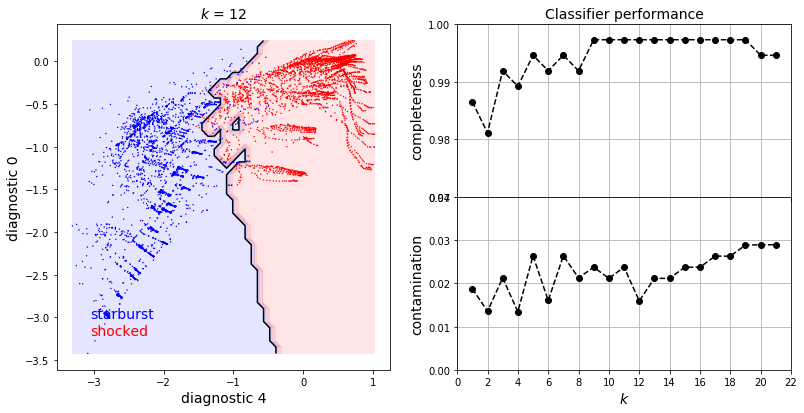

In [123]:
# COMPUTE AND PLOT DECISION BOUNDARY FOR 1 CASE, PLOT MODEL PERFORMANCE

import matplotlib as mpl

k_idx = 11
# selecting one k for plot

clf = classifiers[k_idx]
# classifier for one selected k value

xlim = [np.min(X_train[:, 1]),np.max(X_train[:, 1])]
ylim = [np.min(X_train[:, 0]),np.max(X_train[:, 0])]

# Creating a grid Z of predictions:
xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 50), np.linspace(ylim[0], ylim[1], 50))
Z = clf.predict(np.c_[yy.ravel(), xx.ravel()])
Z = Z.reshape(xx.shape)
# Smooth the boundary:
#from scipy.ndimage import gaussian_filter
#Z = gaussian_filter(Z, 2)

fig = plt.figure(figsize=(12, 6))
fig.subplots_adjust(bottom=0.15, top=0.95, hspace=0.0, left=0.1, right=0.95, wspace=0.2)

# > left plot: data and decision boundary

ax = fig.add_subplot(121)
ax.set_title('$k$ = %s' % kvals[k_idx] , fontsize=14)
ax.set_xlabel('diagnostic 4', fontsize=14)
ax.set_ylabel('diagnostic 0', fontsize=14)
ax.contourf(xx, yy, Z > 0, alpha=0.1, cmap=cmap)
ax.contour(xx, yy, Z, colors=['k'], linestyles=['-'],levels=[0])
ax.scatter(X_train[:, 1], X_train[:, 0], c=y_train, s=2, lw=0, cmap=cmap, zorder=2)

# legend:
ax.text(0.1,0.15, "starburst", color='blue', transform=ax.transAxes, fontsize=14)
ax.text(0.1,0.10, "shocked",   color='red',  transform=ax.transAxes, fontsize=14)

# > top-right plot: completeness vs k

ax = fig.add_subplot(222)
ax.plot(kvals, completeness, 'o--k' , ms=6)
ax.xaxis.set_major_locator(plt.MultipleLocator(2))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.01))
ax.xaxis.set_major_formatter(plt.NullFormatter())
ax.set_title('Classifier performance', fontsize=14)
ax.set_ylabel('completeness', fontsize=14)
ax.set_xlim(np.min(kvals)-1, np.max(kvals)+1)
ax.set_ylim(0.97, 1.0)
ax.grid(True)

# > bottom-right plot: contamination vs k

ax = fig.add_subplot(224)
ax.plot(kvals, contamination, 'o--k' , ms=6)
ax.xaxis.set_major_locator(plt.MultipleLocator(2))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.01))
ax.xaxis.set_major_formatter(plt.FormatStrFormatter('%i'))
ax.set_xlabel('$k$', fontsize=14)
ax.set_ylabel('contamination', fontsize=14)
ax.set_xlim(np.min(kvals)-1, np.max(kvals)+1)
ax.set_ylim(0.0, 0.04)
ax.grid(True)

plt.show()